### Load required packages

In [1]:
import numpy as np                                       
import pandas as pd                                      
import matplotlib.pyplot as plt                           
import math
import geostatspy.geostats as geostats
import geostatspy
import geostatspy.GSLIB as GSLIB
import matplotlib.pyplot as plt
from scipy import ndimage
from sklearn.model_selection import train_test_split

import tensorflow as tf                                
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model

### Read in training data

In [2]:
# create an example of training data x and label y; 
# practical case should have more tarining data and split train/test sets
x = np.random.rand(1,224,224,1) 
y = np.random.rand(1,1)

In [3]:
nx = x.shape[1]
ny = nx

In [4]:
# code for splitting train and test(validation) data
"""
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=0,shuffle=True) 

#reshape data
Y_train = Y_train.reshape(Y_train.shape[0],-1)  
Y_test = Y_test.reshape(Y_test.shape[0],-1)  

X_train = X_train[:,:,:].reshape([X_train.shape[0],nx,ny,-1])
X_test = X_test[:,:,:,].reshape([X_test.shape[0],nx,ny,-1])
"""

'\nfrom sklearn.model_selection import train_test_split\nX_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=0,shuffle=True) \n\n#reshape data\nY_train = Y_train.reshape(Y_train.shape[0],-1)  \nY_test = Y_test.reshape(Y_test.shape[0],-1)  \n\nX_train = X_train[:,:,:].reshape([X_train.shape[0],nx,ny,-1])\nX_test = X_test[:,:,:,].reshape([X_test.shape[0],nx,ny,-1])\n'

### Train CNN
> Step1: define CNN

In [5]:
from tensorflow.keras.models import Sequential

In [6]:
def CNN_model(lr=1e-6, decay = 1e-4):
    # define neural network model sequentially
    model = Sequential()  
    
    # Feature map 1: (224x224x1) --> (112x112x32)
    model.add(layers.Conv2D(32, kernel_size=(3,3), strides=2, input_shape=[nx,ny,1], padding="same"))  
    model.add(layers.ReLU())
    
    # Feature map 2: (112x112x32) --> (56x56x64)
    model.add(layers.Conv2D(64, kernel_size=(3,3), strides=2, padding="same"))
    model.add(layers.ReLU())
    
    # Feature map 3: (56x56x64) --> (13x13x128)
    model.add(layers.Conv2D(128, kernel_size=(3,3), strides=2, padding="same"))
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D(pool_size=(3, 3),strides=2))
       
    # Feature map 5: (13x13x128) --> (4x4x128) -->2048
    model.add(layers.Conv2D(128, kernel_size=(3,3), strides=2, padding="same"))
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D(pool_size=(3, 3),strides=2,padding='same'))  
    model.add(layers.Flatten())  
    
    # Output layer: 2048 --> 1
    model.add(layers.Dense(1,activation = 'linear'))  

    # Compile the Neural Network - define Loss and optimizer to tune the associated weights
    opt = keras.optimizers.Adam(learning_rate=lr, epsilon=1e-8, decay=decay)  
    model.compile(loss='mse', metrics=['mae','mape'],  optimizer='adam') 
    return model

In [7]:
model = CNN_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 32)      320       
                                                                 
 re_lu (ReLU)                (None, 112, 112, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 re_lu_1 (ReLU)              (None, 56, 56, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 re_lu_2 (ReLU)              (None, 28, 28, 128)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 128)      0

> step2: train CNN

In [8]:
nepoch = 300; batch_size = 1 
model = CNN_model()
tf.random.set_seed(1314)
es = tf.keras.callbacks.EarlyStopping(min_delta = 0.0, monitor='val_loss', patience=50)
history = model.fit(x,  y, batch_size=batch_size, epochs=nepoch, verbose=0, validation_data=(x, y),shuffle=True,)

> step3: check the model performance-MSE and MAE

In [9]:
def model_performance(history,nepoch):                  # visualize error and loss, training and testing over Epochs     
    #plt.tight_layout()
    plt.subplot(1,3,1)
    plt.plot(history.history['loss'],c='red')
    plt.plot(history.history['val_loss'],c='black')
    plt.tick_params(labelsize=12)
    plt.title('CNN Model Loss --- MSE',fontsize=15)
    plt.ylabel('Loss',fontsize=15); plt.xlabel('Epoch',fontsize=15); plt.grid()
    plt.legend(['training', 'validation'], loc='upper right',fontsize=15); plt.xlim([0,nepoch]); plt.ylim([0,0.1])
    
    plt.subplot(1,3,2)
    plt.plot(history.history['mae'],c='red')
    plt.plot(history.history['val_mae'],c='black')
    plt.tick_params(labelsize=12)
    plt.title('CNN Model Metrics --- MAE',fontsize=15)
    plt.ylabel('Metrics-MAE',fontsize=15); plt.xlabel('Epoch',fontsize=15); plt.grid()
    plt.legend(['training', 'validation'], loc='upper right',fontsize=15); plt.xlim([0,nepoch]); plt.ylim([0,0.2])
    #plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.1, wspace=0.3, hspace=0.3)
    #plt.show()
    
    plt.subplot(1,3,3)
    plt.plot(history.history['mape'],c='red')
    plt.plot(history.history['val_mape'],c='black')
    plt.tick_params(labelsize=12)
    plt.title('CNN Model Metrics --- MAPE',fontsize=15)
    plt.ylabel('Metrics-MAPE',fontsize=15); plt.xlabel('Epoch',fontsize=15); plt.grid()
    plt.legend(['training', 'validation'], loc='upper right',fontsize=15); plt.xlim([0,nepoch]); plt.ylim([0,80])
    
    plt.subplots_adjust(left=0.5, bottom=0.0, right=3.0, top=1.0, wspace=0.25, hspace=0.3)
    #plt.tight_layout()
    
    plt.show()

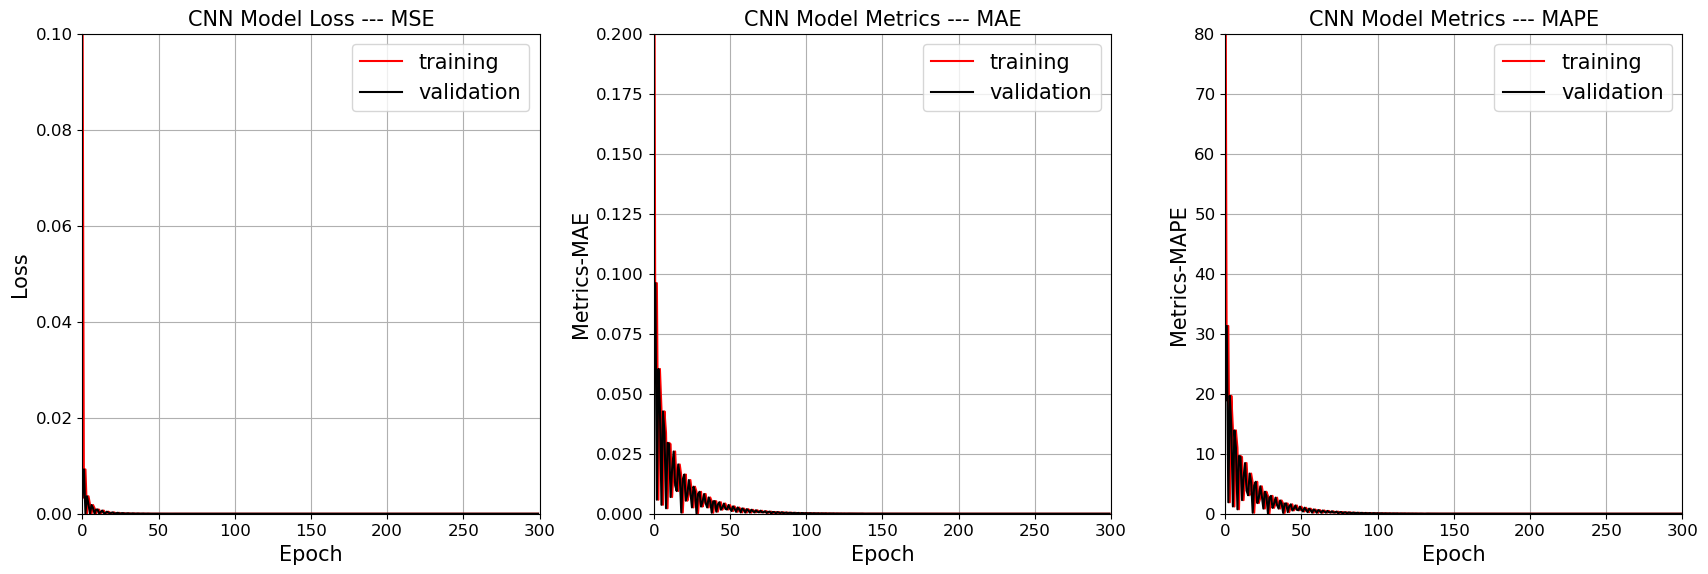

In [10]:
model_performance(history,nepoch)                       # plot loss and accuracy over training Epochs

In [11]:
# use model.predict() to predict properties of interest of testing data
model.predict(np.random.rand(1,224,224,1))

array([[0.29803377]], dtype=float32)